# **Sprint 11 - Proyecto**
---

## **Descripción del proyecto**

**Contexto**

Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios llegan a la etapa de compra. 
- ¿Cuántos usuarios realmente llegan a esta etapa? 
- ¿Cuántos se atascan en etapas anteriores? 
- ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B (sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios participan en experimentos.


**Descripción de los datos**

Cada entrada de registro es una acción de usuario o un evento.

- `EventName`: nombre del evento.

- `DeviceIDHash`: identificador de usuario unívoco.

- `EventTimestamp`: hora del evento.

- `ExpId`: número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba.


## **Desarrollo del proyecto**
- [Paso 1. Abrir el archivo de datos y leer la información general](#paso-1-abrir-el-archivo-de-datos-y-leer-la-informacion-general)
- [Paso 2. Preparar los datos para el análisis](#paso-2-preparar-los-datos-para-el-analisis)
- [Paso 3. Estudiar y comprobar los datos](#paso-3-estudiar-y-comprobar-los-datos)
- [Paso 4. Estudiar el embudo de eventos](#paso-4-estudiar-el-embudo-de-eventos)
- [Paso 5. Estudiar los resultados del experimento](#paso-5-estudiar-los-resultados-del-experimento)


### **Paso 1. Abrir el archivo de datos y leer la información general**
---

Ruta de archivo: `/datasets/logs_exp_us.csv`

In [1]:
# Importando librerías
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Cargando archivo csv como DataFrame
actividad = pd.read_csv('datasets/logs_exp_us.csv', sep='\t')

In [3]:
# Exploración general de archivo
display(actividad.head(4))

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248


### **Paso 2. Preparar los datos para el análisis**
---

#### **Renombrando columnas de forma conveniente.**


In [4]:
# Renombrando columnas
actividad.columns = ['event_name','user_id','event_ts','group']

#### **Comprobación de los tipos de datos, valores duplicados y valores ausentes.**

- Valores duplicados:

In [5]:
# Contando el número de registros duplicados
print('Número de registros duplicados:', actividad.duplicated().sum())


Número de registros duplicados: 413


In [6]:
# Eliminando los registros duplicados
actividad = actividad.drop_duplicates().reset_index(drop=True)
# Corroborando la eliminación
print('Nuevo número de registros duplicados:', actividad.duplicated().sum())

Nuevo número de registros duplicados: 0


- Tipos de datos y valores ausentes:

In [7]:
# Comprobando los tipos de datos y valores ausentes
print(actividad.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  243713 non-null  object
 1   user_id     243713 non-null  int64 
 2   event_ts    243713 non-null  int64 
 3   group       243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB
None


ℹ️ **No existen datos ausentes en ninguna de las columnas.** Es necesario corregir el tipo de dato de la columna 'event_ts', pasando de int64 a datetime. ℹ️

In [8]:
# Convirtiendo columna 'event_ts' al tipo datetime[ns]
actividad['event_ts'] = pd.to_datetime(actividad['event_ts'], unit='s')

- Mejorando nombres de grupos:

In [9]:
# Reemplazado el nombre de los grupos por A1, A2 y B
actividad['group'] = actividad['group'].replace({
    246: "A1",
    247: "A2",
    248: "B"
})


In [10]:
# Verificando que cada usuario único aparezca únicamente en un grupo.
    # Generando una lista de usuarios únicos para cada grupo
users_A1 = actividad.query("group == 'A1'")['user_id'].unique()
users_A2 = actividad.query("group == 'A2'")['user_id'].unique()
users_B = actividad.query("group == 'B'")['user_id'].unique()

ids_repetidos = []

for id in users_A1:
    if id in users_A2:
        if id not in ids_repetidos:
            ids_repetidos.append(id)
    elif id in users_B:
        if id not in ids_repetidos:
            ids_repetidos.append(id)

for id in users_A2:
    if id in users_B:
        if id not in ids_repetidos:
            ids_repetidos.append(id)

print(f'Número de usuarios en diferentes grupos: {len(ids_repetidos)}')


Número de usuarios en diferentes grupos: 0


#### **Agrega una columna de fecha y hora y una columna separada para las fechas.**

In [11]:
# Agregando columnas
    # Columna 'event_hour' da fecha y hora (sin minutos ni segundos) 
actividad['event_hour'] = actividad['event_ts'].dt.floor('h')
    # Columna 'event_date' da funicamente la fecha del evento
actividad['event_date'] = actividad['event_ts'].dt.date
actividad['event_date'] = pd.to_datetime(actividad['event_date'])

# Reordenando columnas
actividad = actividad[['event_name', 'user_id', 'group', 'event_ts', 'event_hour', 'event_date']]

# Mostrando df
actividad.head(5)

,event_name,user_id,group,event_ts,event_hour,event_date
0,MainScreenAppear,4575588528974610257,A1,2019-07-25 04:43:36,2019-07-25 04:00:00,2019-07-25
1,MainScreenAppear,7416695313311560658,A1,2019-07-25 11:11:42,2019-07-25 11:00:00,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,B,2019-07-25 11:28:47,2019-07-25 11:00:00,2019-07-25
3,CartScreenAppear,3518123091307005509,B,2019-07-25 11:28:47,2019-07-25 11:00:00,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,B,2019-07-25 11:48:42,2019-07-25 11:00:00,2019-07-25


### **Paso 3. Estudiar y comprobar los datos**
---

#### **¿Cuántos eventos hay en los registros?**

In [12]:
print(f'En total se cuenta con {len(actividad)} registros de eventos ocurridos.')
print('*************************************************************')
print('Número de registros para cada evento:')

display(actividad.groupby('event_name', as_index=False).agg(event_count=('event_ts', 'count')))

En total se cuenta con 243713 registros de eventos ocurridos.
*************************************************************
Número de registros para cada evento:


,event_name,event_count
0,CartScreenAppear,42668
1,MainScreenAppear,119101
2,OffersScreenAppear,46808
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


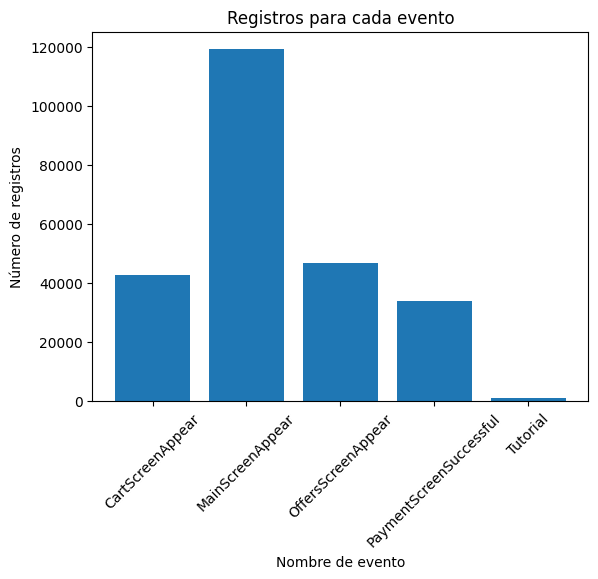

In [13]:
# Graficando número de registros para cada evento:
plt.bar(
    actividad.groupby('event_name', as_index=False).agg(event_count=('event_ts', 'count'))['event_name'],
    actividad.groupby('event_name', as_index=False).agg(event_count=('event_ts', 'count'))['event_count']
)

plt.title('Registros para cada evento')
plt.xlabel('Nombre de evento')
plt.ylabel('Número de registros')
plt.xticks(rotation=45)

plt.show()

#### **¿Cuántos usuarios hay en los registros?**


In [14]:
# Encontrando el numero de usuarios únicos
print(f'''En total se cuenta con {actividad['user_id'].nunique()} usuarios únicos.
Repartidos en 3 grupos (A1, A2 y B)''')
print('********************************************')
# Agrupando por grupo (A1, A2 y B) y contando el número de usuarios únicos para cada grupo
display(actividad.groupby('group', as_index=False).agg(no_users = ('user_id','nunique')))


En total se cuenta con 7551 usuarios únicos.
Repartidos en 3 grupos (A1, A2 y B)
********************************************


,group,no_users
0,A1,2489
1,A2,2520
2,B,2542


#### **¿Cuál es el promedio de eventos por usuario?**

In [15]:
# Agrupando por id de usuario y contando el número de eventos para cada usuario
events_by_user = actividad.groupby('user_id', as_index=False).agg(events_count = ('event_name','count'))
display(events_by_user.head(10))
# Calculando el promedio de eventos por usuario
print(f'El promedio general de eventos por usuario es de: {events_by_user['events_count'].mean():.3f}')
print('********************************************************')

,user_id,events_count
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137
5,8486814028069281,10
6,8740973466195562,9
7,9841258664663090,29
8,12692216027168046,10
9,15708180189885246,126


El promedio general de eventos por usuario es de: 32.276
********************************************************


In [16]:
# Filtrando df events_by_user por grupo (A1, A2 y B)
events_by_userA1 = events_by_user[events_by_user['user_id'].isin(users_A1)]
events_by_userA2 = events_by_user[events_by_user['user_id'].isin(users_A2)]
events_by_userB = events_by_user[events_by_user['user_id'].isin(users_B)]

# Mostrando el promedio de eventos por usuario para cada uno de los grupos
print(f'El promedio de eventos por usuario en el grupo A1 es de: {events_by_userA1['events_count'].mean():.3f}')
print(f'El promedio de eventos por usuario en el grupo A2 es de: {events_by_userA2['events_count'].mean():.3f}')
print(f'El promedio de eventos por usuario en el grupo B es de: {events_by_userB['events_count'].mean():.3f}')
print('****************************************************************')


El promedio de eventos por usuario en el grupo A1 es de: 32.214
El promedio de eventos por usuario en el grupo A2 es de: 30.933
El promedio de eventos por usuario en el grupo B es de: 33.667
****************************************************************


#### **¿Qué periodo de tiempo cubren los datos?**


Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

In [17]:
# Fecha máxima
date_max = actividad['event_date'].max()
# Fecha mínima
date_min = actividad['event_date'].min()

print(f'El periodo comprende del {date_min} al {date_max}')

El periodo comprende del 2019-07-25 00:00:00 al 2019-08-07 00:00:00


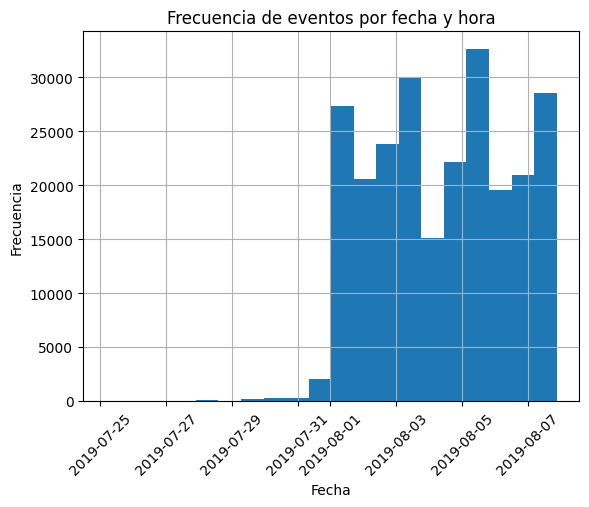

In [18]:
# Graficando histograma
plt.hist(
    actividad['event_hour'],
    bins=20
)

plt.title('Frecuencia de eventos por fecha y hora')
#plt.xlim(date_min, date_max)
plt.xticks(rotation=45)
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

ℹ️ A partir de el histograma se concluye que **no se cuenta con datos completos para todo el periodo.** Los datos comienzan a estar completos a partir del día **1 de Agosto de 2019** ℹ️



In [19]:
# Filtrando datos, trabajar únicamente con lo datos que vayan del 2019-08-01 al 2019-08-07
actividad_efectiva = actividad.query('event_date >= "2019-08-01"')
display(actividad_efectiva.head())

,event_name,user_id,group,event_ts,event_hour,event_date
2826,Tutorial,3737462046622621720,A1,2019-08-01 00:07:28,2019-08-01,2019-08-01
2827,MainScreenAppear,3737462046622621720,A1,2019-08-01 00:08:00,2019-08-01,2019-08-01
2828,MainScreenAppear,3737462046622621720,A1,2019-08-01 00:08:55,2019-08-01,2019-08-01
2829,OffersScreenAppear,3737462046622621720,A1,2019-08-01 00:08:58,2019-08-01,2019-08-01
2830,MainScreenAppear,1433840883824088890,A2,2019-08-01 00:08:59,2019-08-01,2019-08-01


#### **¿Se pierden muchos eventos y usuarios al excluir los datos más antiguos?**


In [20]:
# Creando df que compara la cuenta de eventos para cada evento antes y después del filtrado
event_count_comparison = pd.merge(
    actividad.groupby('event_name', as_index=False).agg(event_count=('event_ts', 'count')),
    actividad_efectiva.groupby('event_name', as_index=False).agg(event_count = ('event_ts', 'count')),
    on='event_name', how='left', suffixes=('', '_filtered')
)
# Calculando cuantos registros se perdieron para cada evento
event_count_comparison['events_lost'] = event_count_comparison['event_count'] - event_count_comparison['event_count_filtered']

print(f'Después del filtrado, en total se cuenta con {len(actividad_efectiva)} registros de eventos ocurridos.')
print(f'Se perdieron en total {event_count_comparison['events_lost'].sum()} eventos.')
print('*************************************************************')
display(event_count_comparison)




Después del filtrado, en total se cuenta con 240887 registros de eventos ocurridos.
Se perdieron en total 2826 eventos.
*************************************************************


,event_name,event_count,event_count_filtered,events_lost
0,CartScreenAppear,42668,42303,365
1,MainScreenAppear,119101,117328,1773
2,OffersScreenAppear,46808,46333,475
3,PaymentScreenSuccessful,34118,33918,200
4,Tutorial,1018,1005,13


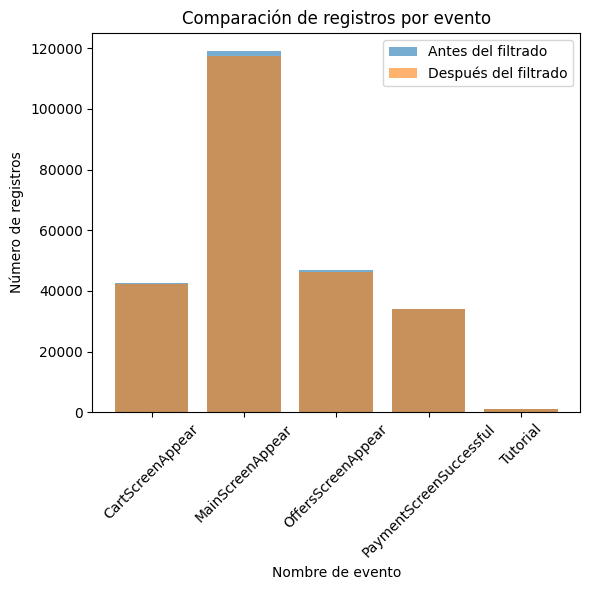

In [21]:
# Gráfico combinado
plt.figure(figsize=(6, 6))

plt.bar(event_count_comparison['event_name'], event_count_comparison['event_count'], alpha=0.6, label='Antes del filtrado')
plt.bar(event_count_comparison['event_name'], event_count_comparison['event_count_filtered'], alpha=0.6, label='Después del filtrado')

plt.title('Comparación de registros por evento')
plt.xlabel('Nombre de evento')
plt.ylabel('Número de registros')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

ℹ️ **NO se pierde una cantidad significativa de eventos.** ℹ️

In [22]:
# Encontrando el numero de usuarios únicos después del filtrado
print(f'''Después del filtrado, en total se cuenta con {actividad_efectiva['user_id'].nunique()} usuarios únicos.
Repartidos en 3 grupos (A1, A2 y B)''')
print('********************************************')

users_count = pd.merge(
    actividad.groupby('group', as_index=False).agg(no_users = ('user_id','nunique')),
    actividad_efectiva.groupby('group', as_index=False).agg(no_users = ('user_id','nunique')),
    on='group', how='left', suffixes=('', '_filtered')
)

users_count['users_lost'] = users_count['no_users'] - users_count['no_users_filtered']

display(users_count)

Después del filtrado, en total se cuenta con 7534 usuarios únicos.
Repartidos en 3 grupos (A1, A2 y B)
********************************************


,group,no_users,no_users_filtered,users_lost
0,A1,2489,2484,5
1,A2,2520,2513,7
2,B,2542,2537,5


ℹ️ **NO se pierde una cantidad significativa de usuarios.** ℹ️

### **Paso 4. Estudiar el embudo de eventos**
---

#### **Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.**


In [23]:
# Calculando la frecuencia de cada evento, ordenando de mayor a menor
actividad_efectiva['event_name'].value_counts()

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: count, dtype: int64

#### **Encuentra la cantidad de usuarios que realizaron cada una de estas acciones.**

Ordena los eventos por el número de usuarios. Calcula la proporción de usuarios que realizaron la acción al menos una vez.

In [24]:
# Calculando la cantidad total de usuarios únicos
total_users = actividad_efectiva['user_id'].nunique()
print(f'En total se cuenta con {total_users} usuarios.')

# Calculando la frecuencia de cada evento y cantidad de usuarios para cada evento, ordenando de mayor a menor
events_count = (
    actividad_efectiva
    .groupby('event_name', as_index=False)
    .agg(event_count=('event_ts', 'count'), unique_users=('user_id', 'nunique'))
    .sort_values('event_count', ascending=False)
)
# Calculando proporción de usuarios que realizaron la acción al menos una vez
events_count['user_proportion'] = events_count['unique_users'] / total_users

display(events_count)


En total se cuenta con 7534 usuarios.


,event_name,event_count,unique_users,user_proportion
1,MainScreenAppear,117328,7419,0.984736
2,OffersScreenAppear,46333,4593,0.609636
0,CartScreenAppear,42303,3734,0.495620
3,PaymentScreenSuccessful,33918,3539,0.469737
4,Tutorial,1005,840,0.111495


#### **¿En qué orden ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.**


ℹ️ Parece ser que el orden de los eventos es el siguiente: ℹ️

1. MainScreenAppear (Aparición de la pantalla principal)
2. OffersScreenAppear (Pantalla de ofertas)
3. CartScreenAppear (Pantalla de carrito de compras)
4.  PaymentScreenSuccessful (Pantalla de compra exitosa)

Por otro lado, también se ha registrado el evento "Tutorial" que parece ser un evento que no forma parte de la secuencia.

#### Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.


In [25]:
# Creando pivot table
actividad_pivot = actividad_efectiva.pivot_table(
    index='user_id',
    columns='event_name',
    values='event_ts',
    aggfunc='min'
)
    # Creando máscaras booleandas
step_1 = ~actividad_pivot['MainScreenAppear'].isna()
step_2 = step_1 & (actividad_pivot['OffersScreenAppear'] > actividad_pivot['MainScreenAppear'])
step_3 = step_2 & (actividad_pivot['CartScreenAppear'] > actividad_pivot['OffersScreenAppear'])
step_4 = step_3 & (actividad_pivot['PaymentScreenSuccessful'] > actividad_pivot['CartScreenAppear'])
    # Filtrando tabla y obteniendo longitud (número de usuarios)
n_main_screen = actividad_pivot[step_1].shape[0]
n_offers_screen = actividad_pivot[step_2].shape[0]
n_cart_screen = actividad_pivot[step_3].shape[0]
n_payment_successful = actividad_pivot[step_4].shape[0]

# Crear el DataFrame (embudo)
events_funnel = pd.DataFrame({
    'event_name': ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'],
    'sequential_users': [n_main_screen, n_offers_screen, n_cart_screen, n_payment_successful]
})
# Calculando la tasa de conversión
events_funnel['conversion_rate'] = events_funnel['sequential_users'] / events_funnel['sequential_users'].shift(1)
events_funnel['conversion_rate'] = events_funnel['conversion_rate'].fillna(1)

display(events_funnel)

,event_name,sequential_users,conversion_rate
0,MainScreenAppear,7419,1.000000
1,OffersScreenAppear,4201,0.566249
2,CartScreenAppear,1767,0.420614
3,PaymentScreenSuccessful,454,0.256933


#### **¿En qué etapa pierdes más usuarios?**


In [26]:
events_funnel['users_lost'] = events_funnel['sequential_users'].shift(1) - events_funnel['sequential_users']

display(events_funnel)


,event_name,sequential_users,conversion_rate,users_lost
0,MainScreenAppear,7419,1.000000,NaN
1,OffersScreenAppear,4201,0.566249,3218.0
2,CartScreenAppear,1767,0.420614,2434.0
3,PaymentScreenSuccessful,454,0.256933,1313.0


ℹ️ La mayor caída en términos de tasa de conversión ocurre entre las etapas **CartScreenAppear y PaymentScreenSuccessful**, con solo un **25.69%** de los usuarios avanzando al pago exitoso. ℹ️ 

Esto sugiere un posible problema en la etapa final del embudo. 

ℹ️ En términos absolutos, la mayor pérdida de usuarios ocurre entre **MainScreenAppear y OffersScreenAppear**, donde se pierden 3,218 usuarios. ℹ️

Sin embargo, la tasa de conversión en esta etapa es de **56.62%**, lo que indica que más de la mitad logra avanzar, aunque el número total de usuarios que abandonan sigue siendo alto. 

#### **¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?**

In [27]:
events_funnel['conversion_from_start'] = events_funnel['sequential_users'] / events_funnel['sequential_users'][0]
display(events_funnel)

,event_name,sequential_users,conversion_rate,users_lost,conversion_from_start
0,MainScreenAppear,7419,1.000000,NaN,1.000000
1,OffersScreenAppear,4201,0.566249,3218.0,0.566249
2,CartScreenAppear,1767,0.420614,2434.0,0.238172
3,PaymentScreenSuccessful,454,0.256933,1313.0,0.061194


ℹ️ **Solo el 6% de los usuarios hacen todo el viaje desde su primer evento hasta el pago** ℹ️

### **Paso 5. Estudiar los resultados del experimento**
---

#### **¿Cuántos usuarios hay en cada grupo?**


In [28]:
# Separando los registros por grupo
actividad_A1 = actividad_efectiva.query("group == 'A1'")
actividad_A2 = actividad_efectiva.query("group == 'A2'")
actividad_B = actividad_efectiva.query("group == 'B'")

# Generando una lista de usuarios únicos para cada grupo
users_A1 = actividad_A1['user_id'].unique()
users_A2 = actividad_A2['user_id'].unique()
users_B = actividad_B['user_id'].unique()

# Mostrando candidad de usuarios para cada grupo
display(actividad_efectiva.groupby('group', as_index=False).agg({'user_id':'nunique'}))

,group,user_id
0,A1,2484
1,A2,2513
2,B,2537


#### **Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.**



#### **Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa.** 

- **Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba).**


In [29]:
# Función para crear un embudo para cada grupo
def create_funnel(df_grupo):
# Creando pivot table
    pivot = df_grupo.pivot_table(
        index='user_id',
        columns='event_name',
        values='event_ts',
        aggfunc='min'
    )
    # Creando máscaras booleandas
    step_1 = ~pivot['MainScreenAppear'].isna()
    step_2 = step_1 & (pivot['OffersScreenAppear'] > pivot['MainScreenAppear'])
    step_3 = step_2 & (pivot['CartScreenAppear'] > pivot['OffersScreenAppear'])
    step_4 = step_3 & (pivot['PaymentScreenSuccessful'] > pivot['CartScreenAppear'])
        # Filtrando tabla y obteniendo longitud (número de usuarios)
    n_main_screen = pivot[step_1].shape[0]
    n_offers_screen = pivot[step_2].shape[0]
    n_cart_screen = pivot[step_3].shape[0]
    n_payment_successful = pivot[step_4].shape[0]

    # Crear el DataFrame (embudo)
    funnel = pd.DataFrame({
        'event_name': ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'],
        'sequential_users': [n_main_screen, n_offers_screen, n_cart_screen, n_payment_successful]
    })
    # Calculando la tasa de conversión
    funnel['conversion_rate'] = funnel['sequential_users'] / funnel['sequential_users'].shift(1)
    funnel['conversion_rate'] = funnel['conversion_rate'].fillna(1)
    # Calculando la tasa de conversión desde el inicio
    funnel['conversion_from_start'] = funnel['sequential_users'] / funnel['sequential_users'][0]

    return funnel

In [30]:
# Definiendo función para realizar test de tasas de conversión.
def ztest_conversion_control (grupo1, grupo2, etapa:int):
    """
    Realiza una prueba Z de proporciones para comparar las tasas de conversión entre dos grupos
    en una etapa específica de un embudo secuencial.

    Parámetros:
    - grupo1 (DataFrame): DataFrame que contiene una columna 'sequential_users' con los conteos acumulados por etapa.
    - grupo2 (DataFrame): DataFrame similar al grupo1, con la misma estructura.
    - etapa (int): Índice de la etapa a evaluar. Debe ser >= 0 y menor que la longitud de los datos.

    Lógica:
    - Si etapa == 0: Lanza advertencia ya que no tiene sentido comparar tasas de conversión sin transición y termina la ejecución de la función.
    - Si etapa > 0: compara la proporción de usuarios que pasan de la etapa anterior a la actual.
    - Si etapa no existe: muestra un mensaje de error y detiene la ejecución.

    La función imprime el estadístico Z, el valor p y un mensaje indicando si la diferencia es estadísticamente significativa (α = 0.05).
    """
    # Éxitos y totales por grupo
    if etapa == 0:
        print("⚠️ No se puede aplicar la prueba Z en la etapa 0: no hay transición previa.")
        return
    elif (etapa > 0) and (etapa < len(grupo1)):
        exitos = [grupo1['sequential_users'][etapa], grupo2['sequential_users'][etapa]]
        totales = [grupo1['sequential_users'][etapa - 1], grupo2['sequential_users'][etapa - 1]]
    else:
        print(f'❌¡ERROR! No existe la etapa {etapa}')
        return
    
    # Prueba Z de proporciones
    stat, p_value = proportions_ztest(exitos, totales)

    print(f'- Estadístico Z: {stat:.3f}')
    print(f'- Valor p: {p_value:.3f}')

    # Valor de significancia
    alpha = 0.05

    if p_value < alpha:
        print("✅ Se rechaza la hipótesis nula, existe diferencia significativa en tasas de conversión.")
    else:
        print("❌ No es posible rechazar la hipótesis nula, no hay diferencia significativa en tasas de conversión.")

In [31]:
# Creando embudos a partir de la función antes definida:
funnel_A1 = create_funnel(actividad_A1)
print('Embudo grupo A1')
display(funnel_A1)

funnel_A2 = create_funnel(actividad_A2)
print('Embudo grupo A2')
display(funnel_A2)

Embudo grupo A1


,event_name,sequential_users,conversion_rate,conversion_from_start
0,MainScreenAppear,2450,1.000000,1.000000
1,OffersScreenAppear,1411,0.575918,0.575918
2,CartScreenAppear,584,0.413891,0.238367
3,PaymentScreenSuccessful,145,0.248288,0.059184


Embudo grupo A2


,event_name,sequential_users,conversion_rate,conversion_from_start
0,MainScreenAppear,2476,1.000000,1.000000
1,OffersScreenAppear,1379,0.556947,0.556947
2,CartScreenAppear,600,0.435098,0.242326
3,PaymentScreenSuccessful,144,0.240000,0.058158


**Prueba A/A** 
(A1/A2)

- **Hipótesis nula:** No existen diferencias significativas en tasas de conversión.
- **Hipótesis alternativa:** Existen diferencias significativas en tasas de conversión.
---

In [32]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][0]}" - A1 vs A2:')
ztest_conversion_control(funnel_A1, funnel_A2, 0)


Test estadístico para la etapa "MainScreenAppear" - A1 vs A2:
⚠️ No se puede aplicar la prueba Z en la etapa 0: no hay transición previa.


In [33]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][1]}" - A1 vs A2:')
ztest_conversion_control(funnel_A1, funnel_A2, 1)


Test estadístico para la etapa "OffersScreenAppear" - A1 vs A2:
- Estadístico Z: 1.343
- Valor p: 0.179
❌ No es posible rechazar la hipótesis nula, no hay diferencia significativa en tasas de conversión.


In [34]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][2]}" - A1 vs A2:')
ztest_conversion_control(funnel_A1, funnel_A2, 2)

Test estadístico para la etapa "CartScreenAppear" - A1 vs A2:
- Estadístico Z: -1.133
- Valor p: 0.257
❌ No es posible rechazar la hipótesis nula, no hay diferencia significativa en tasas de conversión.


In [35]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][3]}" - A1 vs A2:')
ztest_conversion_control(funnel_A1, funnel_A2, 3)

Test estadístico para la etapa "PaymentScreenSuccessful" - A1 vs A2:
- Estadístico Z: 0.332
- Valor p: 0.740
❌ No es posible rechazar la hipótesis nula, no hay diferencia significativa en tasas de conversión.


- **¿Puedes confirmar que los grupos se dividieron correctamente?**

ℹ️ **No se observaron diferencias** significativas en las tasas de conversión entre los grupos A1 y A2 en ninguna de las etapas evaluadas.** ℹ️ 

Esto indica que **la prueba A/A fue exitosa**, ya que ambos grupos se comportaron de manera consistente.

#### **Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?**



In [36]:
# Definiendo función para realizar test de tasas de conversión.
def ztest_conversion (grupo1, grupo2, etapa:int):
    """
    Realiza una prueba Z de proporciones para comparar las tasas de conversión entre dos grupos
    en una etapa específica de un embudo secuencial.

    Parámetros:
    - grupo1 (DataFrame): DataFrame con datos de control que contiene una columna 'sequential_users' con los conteos acumulados por etapa.
    - grupo2 (DataFrame): DataFrame con datos de fuentes alteradas, con la misma estructura que grupo1.
    - etapa (int): Índice de la etapa a evaluar. Debe ser >= 0 y menor que la longitud de los datos.

    Lógica:
    - Si etapa == 0: Lanza advertencia ya que no tiene sentido comparar tasas de conversión sin transición y termina la ejecución de la función.
    - Si etapa > 0: compara la proporción de usuarios que pasan de la etapa anterior a la actual.
    - Si etapa no existe: muestra un mensaje de error y detiene la ejecución.

    La función imprime el estadístico Z, el valor p y un mensaje indicando si la diferencia es estadísticamente significativa (α = 0.05).
    """
    # Éxitos y totales por grupo
    if etapa == 0:
        print("⚠️ No se puede aplicar la prueba Z en la etapa 0: no hay transición previa.")
        return
    elif (etapa > 0) and (etapa < len(grupo1)):
        exitos = [grupo1['sequential_users'][etapa], grupo2['sequential_users'][etapa]]
        totales = [grupo1['sequential_users'][etapa - 1], grupo2['sequential_users'][etapa - 1]]
    else:
        print(f'❌¡ERROR! No existe la etapa {etapa}')
        return
    
    # Prueba Z de proporciones
    stat, p_value = proportions_ztest(exitos, totales)

    print(f'- Estadístico Z: {stat:.3f}')
    print(f'- Valor p: {p_value/2:.3f}')

    # Valor de significancia
    alpha = 0.05

    if ((p_value/2) < alpha) and (grupo1['conversion_rate'][etapa] < grupo2['conversion_rate'][etapa]):
        print("✅ Se rechaza la hipótesis nula, la tasa de conversión en B es mayor a la tasa de conversión en A.")
    else:
        print("❌ No es posible rechazar la hipótesis nula, no exite diferencia significativa en tasas de conversión.")

**A1/B**

- **Hipótesis nula:** La tasa de conversión de B es MENOR o IGUAL a la tasa de conversión de A1.
- **Hipótesis alternativa:** La tasa de conversión de B es MAYOR a la tasa de conversión de A1.
---

In [37]:
funnel_A1 = create_funnel(actividad_A1)
print('Embudo grupo A1:')
display(funnel_A1)

funnel_B = create_funnel(actividad_B)
print('Embudo grupo B:')
display(funnel_B)

Embudo grupo A1:


,event_name,sequential_users,conversion_rate,conversion_from_start
0,MainScreenAppear,2450,1.000000,1.000000
1,OffersScreenAppear,1411,0.575918,0.575918
2,CartScreenAppear,584,0.413891,0.238367
3,PaymentScreenSuccessful,145,0.248288,0.059184


Embudo grupo B:


,event_name,sequential_users,conversion_rate,conversion_from_start
0,MainScreenAppear,2493,1.000000,1.000000
1,OffersScreenAppear,1411,0.565985,0.565985
2,CartScreenAppear,583,0.413182,0.233855
3,PaymentScreenSuccessful,165,0.283019,0.066185


In [38]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][0]}" - A1 vs B:')
ztest_conversion(funnel_A1, funnel_B, 0)

Test estadístico para la etapa "MainScreenAppear" - A1 vs B:
⚠️ No se puede aplicar la prueba Z en la etapa 0: no hay transición previa.


In [39]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][1]}" - A1 vs B:')
ztest_conversion(funnel_A1, funnel_B, 1)

Test estadístico para la etapa "OffersScreenAppear" - A1 vs B:
- Estadístico Z: 0.706
- Valor p: 0.240
❌ No es posible rechazar la hipótesis nula, no exite diferencia significativa en tasas de conversión.


In [40]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][2]}" - A1 vs B:')
ztest_conversion(funnel_A1, funnel_B, 2)

Test estadístico para la etapa "CartScreenAppear" - A1 vs B:
- Estadístico Z: 0.038
- Valor p: 0.485
❌ No es posible rechazar la hipótesis nula, no exite diferencia significativa en tasas de conversión.


In [41]:
print(f'Test estadístico para la etapa "{funnel_A1['event_name'][3]}" - A1 vs B:')
ztest_conversion(funnel_A1, funnel_B, 3)

Test estadístico para la etapa "PaymentScreenSuccessful" - A1 vs B:
- Estadístico Z: -1.343
- Valor p: 0.090
❌ No es posible rechazar la hipótesis nula, no exite diferencia significativa en tasas de conversión.


ℹ️ Al realizar la prueba de hipótesis entre A1/B, **no se observan diferencias significativas en las tasas de conversión en ninguna de las etapas.** ℹ️

**A2/B**

- **Hipótesis nula:** La tasa de conversión de B es MENOR o IGUAL a la tasa de conversión de A2.
- **Hipótesis alternativa:** La tasa de conversión de B es MAYOR a la tasa de conversión de A2.
---

In [42]:
funnel_A2 = create_funnel(actividad_A2)
print('Embudo grupo A2:')
display(funnel_A2)

funnel_B = create_funnel(actividad_B)
print('Embudo grupo B:')
display(funnel_B)

Embudo grupo A2:


,event_name,sequential_users,conversion_rate,conversion_from_start
0,MainScreenAppear,2476,1.000000,1.000000
1,OffersScreenAppear,1379,0.556947,0.556947
2,CartScreenAppear,600,0.435098,0.242326
3,PaymentScreenSuccessful,144,0.240000,0.058158


Embudo grupo B:


,event_name,sequential_users,conversion_rate,conversion_from_start
0,MainScreenAppear,2493,1.000000,1.000000
1,OffersScreenAppear,1411,0.565985,0.565985
2,CartScreenAppear,583,0.413182,0.233855
3,PaymentScreenSuccessful,165,0.283019,0.066185


In [43]:
print(f'Test estadístico para la etapa "{funnel_A2['event_name'][0]}" - A2 vs B:')
ztest_conversion(funnel_A2, funnel_B, 0)

Test estadístico para la etapa "MainScreenAppear" - A2 vs B:
⚠️ No se puede aplicar la prueba Z en la etapa 0: no hay transición previa.


In [44]:
print(f'Test estadístico para la etapa "{funnel_A2['event_name'][1]}" - A2 vs B:')
ztest_conversion(funnel_A2, funnel_B, 1)

Test estadístico para la etapa "OffersScreenAppear" - A2 vs B:
- Estadístico Z: -0.642
- Valor p: 0.260
❌ No es posible rechazar la hipótesis nula, no exite diferencia significativa en tasas de conversión.


In [45]:
print(f'Test estadístico para la etapa "{funnel_A2['event_name'][2]}" - A2 vs B:')
ztest_conversion(funnel_A2, funnel_B, 2)

Test estadístico para la etapa "CartScreenAppear" - A2 vs B:
- Estadístico Z: 1.171
- Valor p: 0.121
❌ No es posible rechazar la hipótesis nula, no exite diferencia significativa en tasas de conversión.


In [46]:
print(f'Test estadístico para la etapa "{funnel_A2['event_name'][3]}" - A2 vs B:')
ztest_conversion(funnel_A2, funnel_B, 3)

Test estadístico para la etapa "PaymentScreenSuccessful" - A2 vs B:
- Estadístico Z: -1.684
- Valor p: 0.046
✅ Se rechaza la hipótesis nula, la tasa de conversión en B es mayor a la tasa de conversión en A.


ℹ️ Al realizar la prueba de hipótesis entre A2/B, **se observa diferencia significativa en las tasas de conversión para la etapa final, Payment Screen Successful.** ℹ️

‼️ La tasa de conversión en el grupo B es mayor a la tasa del conversión del grupo A2.

**A1+A2/B**

- **Hipótesis nula:** La tasa de conversión de B es MENOR o IGUAL a la tasa de conversión de A1&A2 (datos combinados).
- **Hipótesis alternativa:** La tasa de conversión de B es MAYOR a la tasa de conversión de A1&A2 (datos combinados).
 ---

In [47]:
# Uniendo actividad de los dos grupos de control
actividad_A1_A2 = pd.concat([actividad_A1, actividad_A2])
# Creando embudo considerando ambos grupos de control como uno solo
funnel_A1_A2 = create_funnel(actividad_A1_A2)

In [48]:
print('Embudo grupo A (Combinado):')
display(funnel_A1_A2)
print('Embudo grupo B:')
display(funnel_B)

Embudo grupo A (Combinado):


,event_name,sequential_users,conversion_rate,conversion_from_start
0,MainScreenAppear,4926,1.000000,1.000000
1,OffersScreenAppear,2790,0.566382,0.566382
2,CartScreenAppear,1184,0.424373,0.240357
3,PaymentScreenSuccessful,289,0.244088,0.058668


Embudo grupo B:


,event_name,sequential_users,conversion_rate,conversion_from_start
0,MainScreenAppear,2493,1.000000,1.000000
1,OffersScreenAppear,1411,0.565985,0.565985
2,CartScreenAppear,583,0.413182,0.233855
3,PaymentScreenSuccessful,165,0.283019,0.066185


In [49]:
print(f'Test estadístico para la etapa "{funnel_A1_A2['event_name'][0]}" - A1 & A2 vs B:')
ztest_conversion(funnel_A1_A2, funnel_B, 0)

Test estadístico para la etapa "MainScreenAppear" - A1 & A2 vs B:
⚠️ No se puede aplicar la prueba Z en la etapa 0: no hay transición previa.


In [50]:
print(f'Test estadístico para la etapa "{funnel_A1_A2['event_name'][1]}" - A1 & A2 vs B:')
ztest_conversion(funnel_A1_A2, funnel_B, 1)

Test estadístico para la etapa "OffersScreenAppear" - A1 & A2 vs B:
- Estadístico Z: 0.033
- Valor p: 0.487
❌ No es posible rechazar la hipótesis nula, no exite diferencia significativa en tasas de conversión.


In [51]:
print(f'Test estadístico para la etapa "{funnel_A1_A2['event_name'][2]}" - A1 & A2 vs B:')
ztest_conversion(funnel_A1_A2, funnel_B, 2)

Test estadístico para la etapa "CartScreenAppear" - A1 & A2 vs B:
- Estadístico Z: 0.694
- Valor p: 0.244
❌ No es posible rechazar la hipótesis nula, no exite diferencia significativa en tasas de conversión.


In [52]:
print(f'Test estadístico para la etapa "{funnel_A1_A2['event_name'][3]}" - A1 & A2 vs B:')
ztest_conversion(funnel_A1_A2, funnel_B, 3)

Test estadístico para la etapa "PaymentScreenSuccessful" - A1 & A2 vs B:
- Estadístico Z: -1.761
- Valor p: 0.039
✅ Se rechaza la hipótesis nula, la tasa de conversión en B es mayor a la tasa de conversión en A.


ℹ️ Al realizar la prueba de hipótesis entre A/B, **se observa diferencia significativa en las tasas de conversión para la etapa final, Payment Screen Successful.** ℹ️

‼️✅ La tasa de conversión en el grupo B es mayor a la tasa del conversión del grupo A combinado.

#### **¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso.**

- **¿Cuál debería ser el nivel de significancia? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.**

ℹ️ Se han reaizado **12 pruebas de hipótesis estadística con un nivel de significancia alpha de 0.05**. Esto implica que la probabilidad de obtener al menos un falso positivo (rechazar incorrectamente la hipótesis nula) es de aproximadamente 46%. ℹ️

Es necesario realizar un ajuste al nivel de significancia alpha con el método de Corrección de Bonferroni: dividiendo el valor de alpha entre el número de pruebas (0.05 / 12), obteniendo un nuevo valor alpha de 0.00417.

Este nuevo valor de α es muy estricto, lo que reduce considerablemente la probabilidad de falsos positivos, pero **aumenta el riesgo de falsos negativos**, es decir, de no detectar diferencias que realmente existen.

Dado que se comprobó previamente que **no existen diferencias significativas entre los grupos A1 y A2**, se tomó la desición de realizar las pruebas nuevamente únicamente para A1+A2/B. Por lo tanto se realizarán únicamente 3 pruebas. **De esta forma el nuevo valor alpha será: alpha = 0.05 / 3 = 0.0167.**

Esta estrategia permite un análisis más eficiente y sensible, sin comprometer el control del error tipo I.

In [53]:
# Definiendo función para realizar test de tasas de conversión.
def ztest_AB_alpha_corr (grupo1, grupo2, etapa:int):
    """
    Realiza una prueba Z de proporciones para comparar las tasas de conversión entre dos grupos
    en una etapa específica de un embudo secuencial.

    Parámetros:
    - grupo1 (DataFrame): DataFrame con datos de control que contiene una columna 'sequential_users' con los conteos acumulados por etapa.
    - grupo2 (DataFrame): DataFrame con datos de fuentes alteradas, con la misma estructura que grupo1.
    - etapa (int): Índice de la etapa a evaluar. Debe ser >= 0 y menor que la longitud de los datos.

    Lógica:
    - Si etapa == 0: Lanza advertencia ya que no tiene sentido comparar tasas de conversión sin transición y termina la ejecución de la función.
    - Si etapa > 0: compara la proporción de usuarios que pasan de la etapa anterior a la actual.
    - Si etapa no existe: muestra un mensaje de error y detiene la ejecución.

    La función imprime el estadístico Z, el valor p y un mensaje indicando si la diferencia es estadísticamente significativa (α/3 = 0.0167).
    """
    # Éxitos y totales por grupo
    if etapa == 0:
        print("⚠️ No se puede aplicar la prueba Z en la etapa 0: no hay transición previa.")
        return
    elif (etapa > 0) and (etapa < len(grupo1)):
        exitos = [grupo1['sequential_users'][etapa], grupo2['sequential_users'][etapa]]
        totales = [grupo1['sequential_users'][etapa - 1], grupo2['sequential_users'][etapa - 1]]
    else:
        print(f'❌¡ERROR! No existe la etapa {etapa}')
        return
    
    # Prueba Z de proporciones
    stat, p_value = proportions_ztest(exitos, totales)

    print(f'- Estadístico Z: {stat:.3f}')
    print(f'- Valor p: {p_value/2:.3f}')

    # Valor de significancia
    alpha = 0.05 / 3 # Ajuste de valor de significancia

    if ((p_value/2) < alpha) and (grupo1['conversion_rate'][etapa] < grupo2['conversion_rate'][etapa]):
        print("✅ Se rechaza la hipótesis nula, la tasa de conversión en B es mayor a la tasa de conversión en A.")
    else:
        print("❌ No es posible rechazar la hipótesis nula, no exite diferencia significativa en tasas de conversión.")

**A/B Test:**

- **Hipótesis nula:** La tasa de conversión de B es MENOR o IGUAL a la tasa de conversión de A1&A2 (datos combinados).
- **Hipótesis alternativa:** La tasa de conversión de B es MAYOR a la tasa de conversión de A1&A2 (datos combinados).
---

In [54]:
print(f'Test estadístico para la etapa "{funnel_A1_A2['event_name'][1]}" - A1 & A2 vs B:')
ztest_AB_alpha_corr(funnel_A1_A2, funnel_B, 1)

Test estadístico para la etapa "OffersScreenAppear" - A1 & A2 vs B:
- Estadístico Z: 0.033
- Valor p: 0.487
❌ No es posible rechazar la hipótesis nula, no exite diferencia significativa en tasas de conversión.


In [55]:
print(f'Test estadístico para la etapa "{funnel_A1_A2['event_name'][2]}" - A1 & A2 vs B:')
ztest_AB_alpha_corr(funnel_A1_A2, funnel_B, 2)

Test estadístico para la etapa "CartScreenAppear" - A1 & A2 vs B:
- Estadístico Z: 0.694
- Valor p: 0.244
❌ No es posible rechazar la hipótesis nula, no exite diferencia significativa en tasas de conversión.


In [56]:
print(f'Test estadístico para la etapa "{funnel_A1_A2['event_name'][3]}" - A1 & A2 vs B:')
ztest_AB_alpha_corr(funnel_A1_A2, funnel_B, 3)

Test estadístico para la etapa "PaymentScreenSuccessful" - A1 & A2 vs B:
- Estadístico Z: -1.761
- Valor p: 0.039
❌ No es posible rechazar la hipótesis nula, no exite diferencia significativa en tasas de conversión.


**Resultados de A/B test:**

🧠 Después de realizadas las pruebas de hipótesis con el nivel de significancia ajustado, se concluye que **no existen diferencias significativas en las tasas de conversión entre los grupos A (control) y B (prueba).**